# Deterministic RNNs in SSM

To fit the distributional notation of SSM-JAX, deterministic RNNs return _deterministic_ distributions over the output values.

This is accomplished by using the Tensorflow Probability `Deterministic` distribution.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as np
import jax.random as jr

from ssm.rnn import GRU

In [4]:
from matplotlib.gridspec import GridSpec 
import matplotlib.pyplot as plt

def plot_emissions(states, data):
    latent_dim = states.shape[-1]
    emissions_dim = data.shape[-1]
    num_timesteps = data.shape[0]
    
    plt.figure(figsize=(8, 6))
    gs = GridSpec(2, 1, height_ratios=(1, emissions_dim / latent_dim))

    lim = abs(states).max()
    plt.subplot(gs[0])
    for d in range(latent_dim):
        plt.plot(states[:, d] + lim * d, '-')
    plt.yticks(np.arange(latent_dim) * lim, ["$x_{}$".format(d+1) for d in range(latent_dim)])
    plt.xticks([])
    plt.xlim(0, num_timesteps)
    plt.title("Sampled Latent States")

    lim = abs(data).max()
    plt.subplot(gs[1])
    for n in range(emissions_dim):
        plt.plot(data[:, n] - lim * n, '-k')
    plt.yticks(-np.arange(emissions_dim) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(emissions_dim)])
    plt.xlabel("time")
    plt.xlim(0, num_timesteps)

    plt.title("Sampled Emissions")
    plt.tight_layout()

## Create a "true" RNN model

Let the emissions be the identity of the hidden states.

In [37]:
num_input_dims = 1
num_latent_dims = 1

rnn = GRU(num_input_dims, num_latent_dims, seed=jr.PRNGKey(0))

In [119]:
seed_1, seed_2, seed_3, seed_4 = jr.split(jr.PRNGKey(0), 4)
num_timesteps = 100
num_trials = 100

# generate train data
train_inputs = jr.normal(seed_1, shape=(num_trials, num_timesteps, num_input_dims))
train_states, train_dataset = rnn.sample(key=seed_2, covariates=train_inputs, num_steps=num_timesteps, num_samples=num_trials)

# generate test data
test_inputs = jr.normal(seed_3, shape=(num_trials, num_timesteps, num_input_dims))
test_states, test_dataset = rnn.sample(key=seed_4, covariates=test_inputs, num_steps=num_timesteps, num_samples=num_trials)

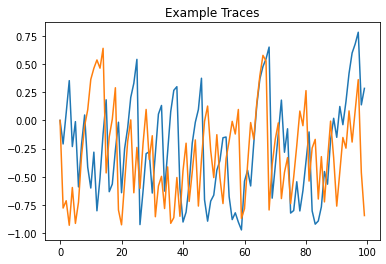

In [121]:
plt.plot(train_dataset[0], label="train")
plt.plot(test_dataset[0], label="test")
plt.title("Example Traces")
plt.show()

# Create our Test RNN to fit to the data

In [106]:
num_input_dims = 1
num_latent_dims = 1

test_rnn = GRU(num_input_dims, num_latent_dims, seed=jr.PRNGKey(42))

In [125]:
from jax import value_and_grad, jit
from jax.experimental import optimizers
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

@jit
def mse_loss(model, inputs, labels, seed):
    num_steps = inputs.shape[-2]
    _, pred_data = model.sample(key=seed, num_steps=num_steps, covariates=inputs)
    return np.mean(np.square(pred_data - labels))


@jit
def step(step, opt_state, seed):
    value, grads = value_and_grad(mse_loss)(opt.params_fn(opt_state), inputs, labels, seed)
    opt_state = opt.update_fn(step, grads, opt_state)
    return value, opt_state


seed = jr.PRNGKey(0)
num_epochs = 100
train_losses = []
val_losses = []

opt = optimizers.adam(step_size=1e-3)
opt_state = opt.init_fn(test_rnn)
for epoch in tqdm(range(1, num_epochs + 1)):
    for i, (inputs, labels) in tqdm(
        enumerate(zip(train_inputs, train_dataset)), total=num_trials, leave=False
    ):
        seed, this_seed = jr.split(seed, 2)
        loss, opt_state = step(epoch * i, opt_state, this_seed)
        train_losses.append(loss)
        
    # validation
    val_loss = 0.
    for (test_input, test_label) in zip(test_inputs, test_dataset):
        val_loss += mse_loss(opt.params_fn(opt_state), test_input, test_label, this_seed)
    val_loss /= test_dataset.shape[0]
    val_losses.append(val_loss)


100%|██████████| 100/100 [00:04<00:00, 24.41it/s]


Text(0, 0.5, 'mse loss')

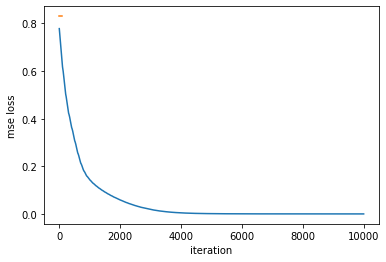

In [124]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("iteration")
plt.ylabel("mse loss")

In [109]:
fit_rnn = opt.params_fn(opt_state)

test_states, test_data = test_rnn.sample(key=jr.PRNGKey(0), covariates=train_inputs, num_steps=num_timesteps, num_samples=num_trials)
fit_states, fit_data = fit_rnn.sample(key=jr.PRNGKey(0), covariates=train_inputs, num_steps=num_timesteps, num_samples=num_trials)

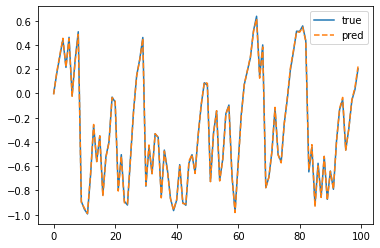

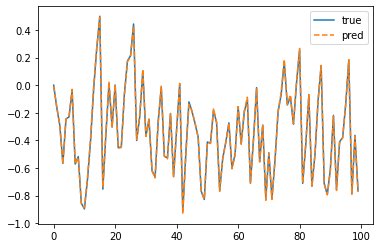

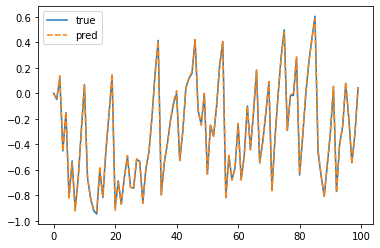

In [111]:
for idx in range(3):
    plt.plot(train_dataset[idx], label="true")
    plt.plot(fit_data[idx], '--', label="pred")
    plt.legend()
    plt.show()